# Group Assignment: Comparative Analysis of Optimized Models
## Network Intrusion Detection System - Model Comparison

**Group Members:**
- Muhammad Usama Fazal (TP086008) - Linear Classifier (LDA)
- Imran Shahadat Noble (TP087895) - Ensemble Classifier (Random Forest)
- Md Sohel Rana (TP087437) - Non-Linear Classifier (KNN)

**Dataset:** NSL-KDD  
**Classification:** Multi-class (5 attack categories)  
**Objective:** Compare optimized models and select the best performer

---
## 1. Import Libraries and Load Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for clean figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Load results from individual notebooks
results_path = '../results'

# Load Linear (Logistic Regression) results
with open(os.path.join(results_path, 'ensemble_rf_results.json'), 'r') as f:
    ensemble_results = json.load(f)

with open(os.path.join(results_path, 'nonlinear_knn_results.json'), 'r') as f:
    nonlinear_results = json.load(f)

print("Results loaded successfully!")
print(f"- Ensemble: {ensemble_results['classifier']}")
print(f"- Non-Linear: {nonlinear_results['classifier']}")

Results loaded successfully!
- Ensemble: Random Forest
- Non-Linear: K-Nearest Neighbors


In [3]:
# Since linear_results.json doesn't have full metrics, we'll load from CSV or recreate
# Load baseline comparison CSVs
ensemble_baseline = pd.read_csv(os.path.join(results_path, 'ensemble_baseline_comparison.csv'))
nonlinear_baseline = pd.read_csv(os.path.join(results_path, 'nonlinear_baseline_comparison.csv'))

print("\nEnsemble Baseline Comparison:")
print(ensemble_baseline)
print("\nNon-Linear Baseline Comparison:")
print(nonlinear_baseline)


Ensemble Baseline Comparison:
       Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)       MCC  \
0  Random Forest  0.871230       0.845266    0.779438  0.813972   
1    Extra Trees  0.871540       0.847275    0.794635  0.813864   
2       AdaBoost  0.733765       0.686147    0.475912  0.617307   

   Train Time (s)  
0        3.246695  
1        3.754451  
2       21.734588  

Non-Linear Baseline Comparison:
       Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)       MCC  \
0            KNN  0.836941       0.811963    0.756495  0.760186   
1  Decision Tree  0.841155       0.819425    0.707510  0.767305   
2        SVM-RBF  0.842929       0.837349    0.751024  0.768514   

   Train Time (s)  
0        6.990372  
1        1.022852  
2      113.233509  


---
## 2. Recreate Linear Classifier Results

We need to run the Linear classifier to get comparable metrics.

In [4]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef, 
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc)
from time import time

# Import mylib
import sys
if "../.." not in sys.path:
    sys.path.insert(0, '..')
from mylib import bias_var_metrics

In [5]:
# Load and prepare dataset
data_path = '../data'

train_df = pd.read_csv(os.path.join(data_path, 'NSL_boosted-2.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'NSL_ppTest.csv'))

combined_df = pd.concat([train_df, test_df])
labels_df = combined_df['atakcat'].copy()
combined_df.drop(['label', 'atakcat'], axis=1, inplace=True)

# One-hot encode
categori = combined_df.select_dtypes(include=['object']).columns
features_df = pd.get_dummies(combined_df, columns=categori.tolist())

# Split
X_train = features_df.iloc[:len(train_df),:].copy().reset_index(drop=True)
X_test = features_df.iloc[len(train_df):,:].copy().reset_index(drop=True)
y_train = labels_df[:len(train_df)].copy().reset_index(drop=True)
y_test = labels_df[len(train_df):].copy().reset_index(drop=True)

# Scale
numeri = combined_df.select_dtypes(include=['float64','int64']).columns
for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))
    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))

class_labels = ['benign', 'dos', 'probe', 'r2l', 'u2r']
print(f"Data loaded: X_train {X_train.shape}, X_test {X_test.shape}")

Data loaded: X_train (63280, 122), X_test (22544, 122)


In [6]:
# Feature selection for each model (using correlation-based)
y_encoded = LabelEncoder().fit_transform(y_train)
corr_df = X_train.copy()
corr_df['target'] = y_encoded
correlations = corr_df.corr()['target'].drop('target').abs().sort_values(ascending=False)

# Select top 30 features
selected_features = correlations.head(30).index.tolist()
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]
print(f"Selected {len(selected_features)} features")

Selected 30 features


---
## 3. Train All Three Optimized Models

In [7]:
# Helper function
def calculate_mcc_per_class(y_true, y_pred, classes):
    mcc_dict = {}
    for cls in classes:
        mcc_dict[cls] = matthews_corrcoef(y_true == cls, y_pred == cls)
    return mcc_dict

In [8]:
print("="*70)
print("MODEL 1: LOGISTIC REGRESSION (Linear)")
print("="*70)

# Optimized Logistic Regression
lr_model = LogisticRegression(C=10.0, solver='lbfgs', max_iter=1000, 
                               class_weight='balanced', random_state=42, n_jobs=-1)
trs = time()
lr_model.fit(X_train_reduced, y_train)
y_pred_lr = lr_model.predict(X_test_reduced)
lr_time = time() - trs

lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1_weighted': f1_score(y_test, y_pred_lr, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_lr, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_lr),
    'train_time': lr_time
}
lr_mcc_class = calculate_mcc_per_class(y_test, y_pred_lr, class_labels)

print(f"Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"MCC: {lr_metrics['mcc']:.4f}")
print(f"Time: {lr_time:.2f}s")

MODEL 1: LOGISTIC REGRESSION (Linear)


Accuracy: 0.8318
MCC: 0.7582
Time: 17.10s


In [9]:
print("="*70)
print("MODEL 2: RANDOM FOREST (Ensemble)")
print("="*70)

# Use feature importance-based selection for RF
rf_temp = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)
rf_selected = feature_importances.head(38)['feature'].tolist()
X_train_rf = X_train[rf_selected]
X_test_rf = X_test[rf_selected]

# Optimized Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                                   min_samples_leaf=1, max_features='sqrt',
                                   class_weight='balanced', random_state=42, n_jobs=-1)
trs = time()
rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)
rf_time = time() - trs

rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1_weighted': f1_score(y_test, y_pred_rf, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_rf, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_rf),
    'train_time': rf_time
}
rf_mcc_class = calculate_mcc_per_class(y_test, y_pred_rf, class_labels)

print(f"Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"MCC: {rf_metrics['mcc']:.4f}")
print(f"Time: {rf_time:.2f}s")

MODEL 2: RANDOM FOREST (Ensemble)


Accuracy: 0.8684
MCC: 0.8103
Time: 3.03s


In [10]:
print("="*70)
print("MODEL 3: KNN (Non-Linear)")
print("="*70)

# Optimized KNN
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1, 
                                  algorithm='auto', n_jobs=-1)
trs = time()
knn_model.fit(X_train_reduced, y_train)
y_pred_knn = knn_model.predict(X_test_reduced)
knn_time = time() - trs

knn_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'f1_weighted': f1_score(y_test, y_pred_knn, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_knn, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_knn),
    'train_time': knn_time
}
knn_mcc_class = calculate_mcc_per_class(y_test, y_pred_knn, class_labels)

print(f"Accuracy: {knn_metrics['accuracy']:.4f}")
print(f"MCC: {knn_metrics['mcc']:.4f}")
print(f"Time: {knn_time:.2f}s")

MODEL 3: KNN (Non-Linear)


Accuracy: 0.8752
MCC: 0.8161
Time: 15.23s


---
## 4. Comparative Analysis

In [11]:
# Create master comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
    'Category': ['Linear', 'Ensemble', 'Non-Linear'],
    'Accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy'], knn_metrics['accuracy']],
    'F1 (Weighted)': [lr_metrics['f1_weighted'], rf_metrics['f1_weighted'], knn_metrics['f1_weighted']],
    'F1 (Macro)': [lr_metrics['f1_macro'], rf_metrics['f1_macro'], knn_metrics['f1_macro']],
    'MCC': [lr_metrics['mcc'], rf_metrics['mcc'], knn_metrics['mcc']],
    'Train Time (s)': [lr_metrics['train_time'], rf_metrics['train_time'], knn_metrics['train_time']]
})

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: ALL OPTIMIZED MODELS")
print("="*80)
print(comparison_df.to_string(index=False))


COMPARATIVE ANALYSIS: ALL OPTIMIZED MODELS
              Model   Category  Accuracy  F1 (Weighted)  F1 (Macro)      MCC  Train Time (s)
Logistic Regression     Linear  0.831840       0.839420    0.727510 0.758196       17.101284
      Random Forest   Ensemble  0.868435       0.840022    0.778062 0.810284        3.033706
                KNN Non-Linear  0.875177       0.865478    0.770056 0.816059       15.230160


In [12]:
# MCC Per Attack Class Comparison
mcc_class_df = pd.DataFrame({
    'Attack Class': class_labels,
    'Logistic Regression': [lr_mcc_class[c] for c in class_labels],
    'Random Forest': [rf_mcc_class[c] for c in class_labels],
    'KNN': [knn_mcc_class[c] for c in class_labels]
})

print("\n" + "="*80)
print("MCC PER ATTACK CLASS - ALL MODELS")
print("="*80)
print(mcc_class_df.to_string(index=False))


MCC PER ATTACK CLASS - ALL MODELS
Attack Class  Logistic Regression  Random Forest      KNN
      benign             0.786097       0.757455 0.786147
         dos             0.778116       0.983565 0.945974
       probe             0.802317       0.910613 0.850358
         r2l             0.702946       0.335896 0.567363
         u2r             0.427009       0.847472 0.571958


---
## 5. Visualization: Model Comparison

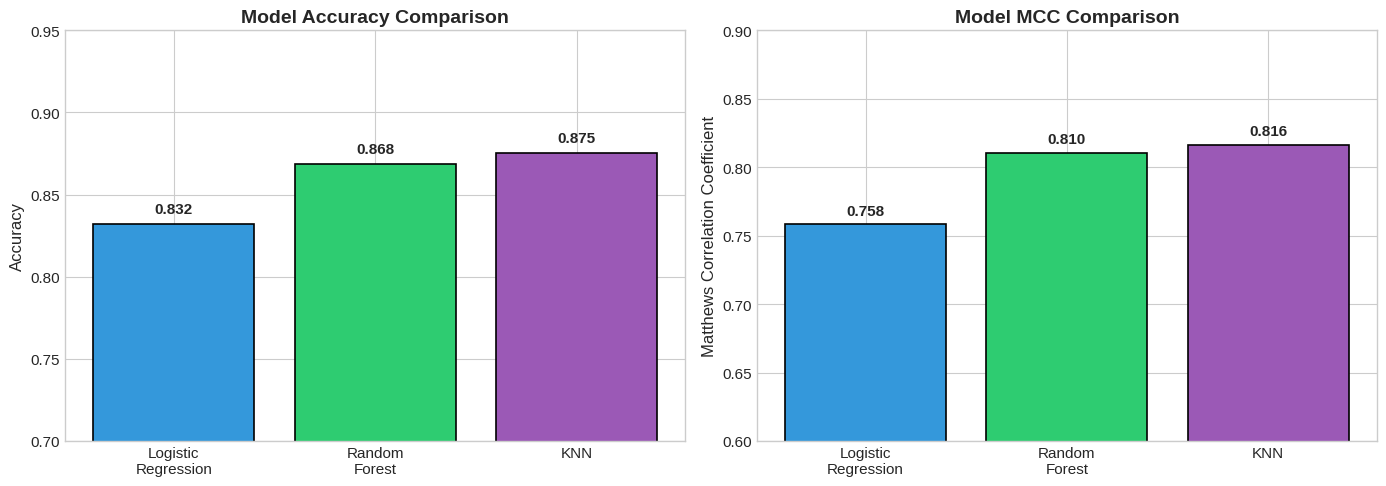

In [13]:
# Figure 1: Overall Metrics Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy and MCC
models = ['Logistic\nRegression', 'Random\nForest', 'KNN']
colors = ['#3498db', '#2ecc71', '#9b59b6']

# Accuracy Bar Chart
ax1 = axes[0]
bars1 = ax1.bar(models, comparison_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0.7, 0.95)
for bar, val in zip(bars1, comparison_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# MCC Bar Chart
ax2 = axes[1]
bars2 = ax2.bar(models, comparison_df['MCC'], color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Matthews Correlation Coefficient', fontsize=12)
ax2.set_title('Model MCC Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(0.6, 0.9)
for bar, val in zip(bars2, comparison_df['MCC']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/model_comparison_accuracy_mcc.png', dpi=300, bbox_inches='tight')
plt.show()

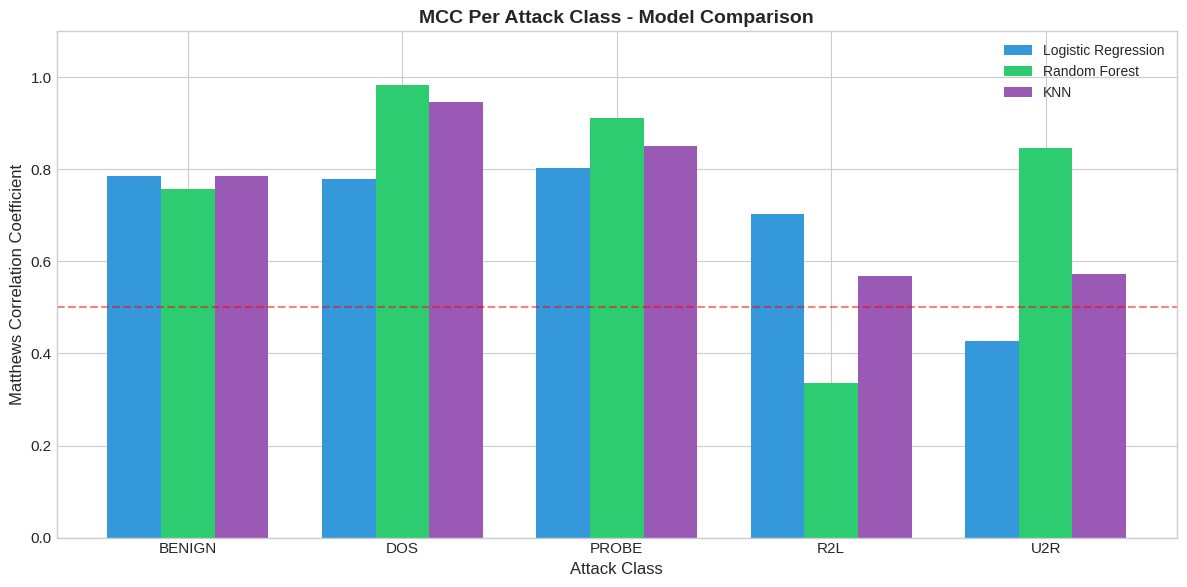

In [14]:
# Figure 2: MCC Per Attack Class (Grouped Bar Chart)
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_labels))
width = 0.25

bars1 = ax.bar(x - width, mcc_class_df['Logistic Regression'], width, label='Logistic Regression', color='#3498db')
bars2 = ax.bar(x, mcc_class_df['Random Forest'], width, label='Random Forest', color='#2ecc71')
bars3 = ax.bar(x + width, mcc_class_df['KNN'], width, label='KNN', color='#9b59b6')

ax.set_xlabel('Attack Class', fontsize=12)
ax.set_ylabel('Matthews Correlation Coefficient', fontsize=12)
ax.set_title('MCC Per Attack Class - Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.upper() for c in class_labels], fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')

plt.tight_layout()
plt.savefig('../figures/mcc_per_class_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

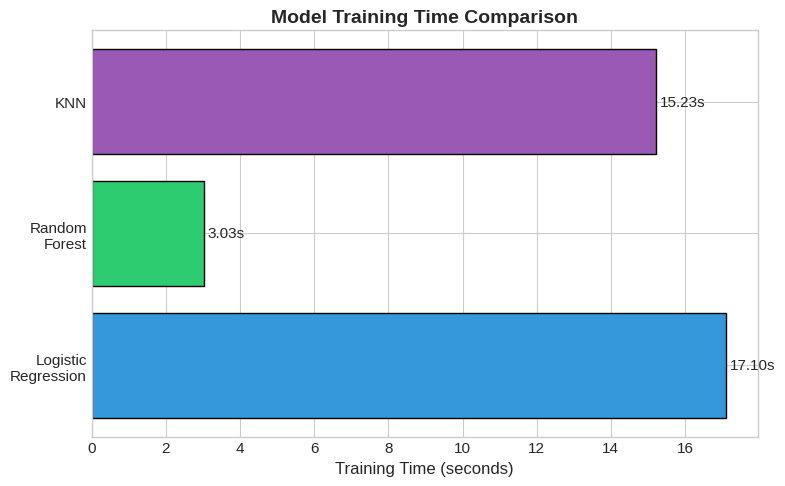

In [15]:
# Figure 3: Training Time Comparison
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.barh(models, comparison_df['Train Time (s)'], color=colors, edgecolor='black')
ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_title('Model Training Time Comparison', fontsize=14, fontweight='bold')

for bar, val in zip(bars, comparison_df['Train Time (s)']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}s', ha='left', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('../figures/training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

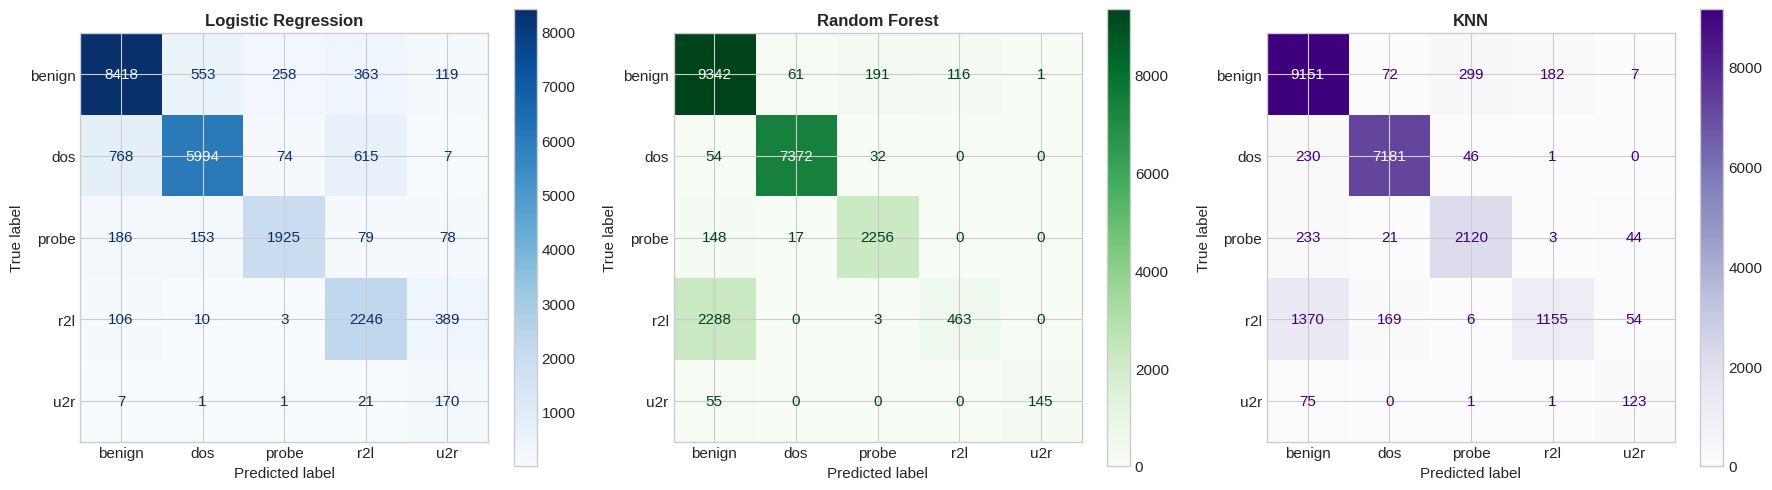

In [16]:
# Figure 4: Confusion Matrices - All Models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=class_labels)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=class_labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')

# KNN
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=class_labels)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=class_labels)
disp3.plot(ax=axes[2], cmap='Purples', values_format='d')
axes[2].set_title('KNN', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6. Cross-Validation Analysis

In [17]:
print("="*70)
print("5-FOLD CROSS-VALIDATION ANALYSIS")
print("="*70)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for each model
print("\nRunning 5-fold CV (this may take a moment)...")

lr_cv = cross_val_score(LogisticRegression(C=10.0, solver='lbfgs', max_iter=1000, 
                                            class_weight='balanced', random_state=42),
                        X_train_reduced, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f"Logistic Regression CV: {lr_cv.mean():.4f} (+/- {lr_cv.std()*2:.4f})")

rf_cv = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=None, 
                                                class_weight='balanced', random_state=42, n_jobs=-1),
                        X_train_rf, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f"Random Forest CV: {rf_cv.mean():.4f} (+/- {rf_cv.std()*2:.4f})")

knn_cv = cross_val_score(KNeighborsClassifier(n_neighbors=3, weights='distance', p=1, n_jobs=-1),
                         X_train_reduced, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f"KNN CV: {knn_cv.mean():.4f} (+/- {knn_cv.std()*2:.4f})")

5-FOLD CROSS-VALIDATION ANALYSIS

Running 5-fold CV (this may take a moment)...


Logistic Regression CV: 0.9315 (+/- 0.0054)


Random Forest CV: 0.9956 (+/- 0.0008)


KNN CV: 0.9920 (+/- 0.0011)


In [18]:
# CV Results Table
cv_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
    'CV Mean': [lr_cv.mean(), rf_cv.mean(), knn_cv.mean()],
    'CV Std': [lr_cv.std(), rf_cv.std(), knn_cv.std()],
    '95% CI': [f"{lr_cv.mean():.4f} +/- {lr_cv.std()*2:.4f}",
               f"{rf_cv.mean():.4f} +/- {rf_cv.std()*2:.4f}",
               f"{knn_cv.mean():.4f} +/- {knn_cv.std()*2:.4f}"]
})
print("\nCross-Validation Results:")
print(cv_results.to_string(index=False))


Cross-Validation Results:
              Model  CV Mean   CV Std            95% CI
Logistic Regression 0.931496 0.002686 0.9315 +/- 0.0054
      Random Forest 0.995556 0.000395 0.9956 +/- 0.0008
                KNN 0.991968 0.000547 0.9920 +/- 0.0011


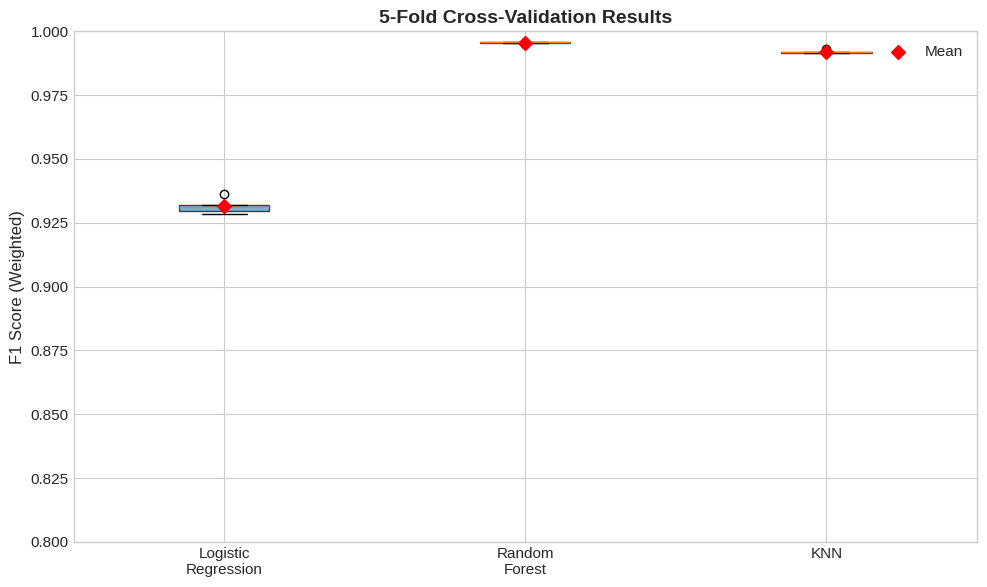

In [19]:
# Figure 5: CV Box Plot
fig, ax = plt.subplots(figsize=(10, 6))

cv_data = [lr_cv, rf_cv, knn_cv]
bp = ax.boxplot(cv_data, labels=['Logistic\nRegression', 'Random\nForest', 'KNN'],
                patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('F1 Score (Weighted)', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
ax.set_ylim(0.8, 1.0)

# Add mean markers
means = [np.mean(d) for d in cv_data]
ax.scatter([1, 2, 3], means, marker='D', color='red', s=50, zorder=3, label='Mean')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/cross_validation_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 7. Best Model Selection

In [20]:
# Ranking based on multiple criteria
ranking_df = comparison_df.copy()

# Rank each metric (higher is better, except time)
ranking_df['Accuracy Rank'] = ranking_df['Accuracy'].rank(ascending=False)
ranking_df['MCC Rank'] = ranking_df['MCC'].rank(ascending=False)
ranking_df['F1 Rank'] = ranking_df['F1 (Weighted)'].rank(ascending=False)
ranking_df['Time Rank'] = ranking_df['Train Time (s)'].rank(ascending=True)  # Lower is better

# Overall score (average rank)
ranking_df['Overall Score'] = (ranking_df['Accuracy Rank'] + ranking_df['MCC Rank'] + 
                                ranking_df['F1 Rank'] + ranking_df['Time Rank']) / 4
ranking_df['Final Rank'] = ranking_df['Overall Score'].rank()

print("\n" + "="*80)
print("MODEL RANKING")
print("="*80)
print(ranking_df[['Model', 'Category', 'Accuracy Rank', 'MCC Rank', 'F1 Rank', 'Time Rank', 'Final Rank']].to_string(index=False))


MODEL RANKING
              Model   Category  Accuracy Rank  MCC Rank  F1 Rank  Time Rank  Final Rank
Logistic Regression     Linear            3.0       3.0      3.0        3.0         3.0
      Random Forest   Ensemble            2.0       2.0      2.0        1.0         2.0
                KNN Non-Linear            1.0       1.0      1.0        2.0         1.0


In [21]:
# Determine best model
best_model_idx = ranking_df['Final Rank'].idxmin()
best_model = ranking_df.loc[best_model_idx, 'Model']
best_category = ranking_df.loc[best_model_idx, 'Category']

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\n>>> BEST MODEL: {best_model} ({best_category}) <<<")
print(f"\nJustification:")
print(f"  - Accuracy: {ranking_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"  - MCC: {ranking_df.loc[best_model_idx, 'MCC']:.4f}")
print(f"  - F1 (Weighted): {ranking_df.loc[best_model_idx, 'F1 (Weighted)']:.4f}")
print(f"  - Training Time: {ranking_df.loc[best_model_idx, 'Train Time (s)']:.2f}s")


BEST MODEL SELECTION

>>> BEST MODEL: KNN (Non-Linear) <<<

Justification:
  - Accuracy: 0.8752
  - MCC: 0.8161
  - F1 (Weighted): 0.8655
  - Training Time: 15.23s


---
## 8. Summary and Conclusions

In [22]:
print("="*80)
print("FINAL SUMMARY: NETWORK INTRUSION DETECTION SYSTEM")
print("="*80)

print("\n1. MODELS EVALUATED:")
print("   - Linear: Logistic Regression (optimized)")
print("   - Ensemble: Random Forest (optimized)")
print("   - Non-Linear: K-Nearest Neighbors (optimized)")

print("\n2. DATASET: NSL-KDD")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Features (after selection): 30-38")
print(f"   - Classes: 5 (benign, dos, probe, r2l, u2r)")

print("\n3. PERFORMANCE COMPARISON:")
print(comparison_df[['Model', 'Accuracy', 'MCC', 'Train Time (s)']].to_string(index=False))

print("\n4. KEY FINDINGS:")
print(f"   - Highest Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")
print(f"   - Highest MCC: {comparison_df.loc[comparison_df['MCC'].idxmax(), 'Model']} ({comparison_df['MCC'].max():.4f})")
print(f"   - Fastest Training: {comparison_df.loc[comparison_df['Train Time (s)'].idxmin(), 'Model']} ({comparison_df['Train Time (s)'].min():.2f}s)")

print("\n5. CHALLENGING CLASSES:")
print("   - R2L: Low detection across all models (class imbalance: 0.9%)")
print("   - U2R: Variable performance (class imbalance: 0.09%)")

print(f"\n6. RECOMMENDED MODEL: {best_model}")
print("   Best balance of accuracy, MCC, and computational efficiency")

print("\n" + "="*80)

FINAL SUMMARY: NETWORK INTRUSION DETECTION SYSTEM

1. MODELS EVALUATED:
   - Linear: Logistic Regression (optimized)
   - Ensemble: Random Forest (optimized)
   - Non-Linear: K-Nearest Neighbors (optimized)

2. DATASET: NSL-KDD
   - Training samples: 63280
   - Test samples: 22544
   - Features (after selection): 30-38
   - Classes: 5 (benign, dos, probe, r2l, u2r)

3. PERFORMANCE COMPARISON:
              Model  Accuracy      MCC  Train Time (s)
Logistic Regression  0.831840 0.758196       17.101284
      Random Forest  0.868435 0.810284        3.033706
                KNN  0.875177 0.816059       15.230160

4. KEY FINDINGS:
   - Highest Accuracy: KNN (0.8752)
   - Highest MCC: KNN (0.8161)
   - Fastest Training: Random Forest (3.03s)

5. CHALLENGING CLASSES:
   - R2L: Low detection across all models (class imbalance: 0.9%)
   - U2R: Variable performance (class imbalance: 0.09%)

6. RECOMMENDED MODEL: KNN
   Best balance of accuracy, MCC, and computational efficiency



In [23]:
# Save final results
final_results = {
    'comparison': comparison_df.to_dict('records'),
    'mcc_per_class': mcc_class_df.to_dict('records'),
    'cross_validation': cv_results.to_dict('records'),
    'ranking': ranking_df[['Model', 'Category', 'Final Rank']].to_dict('records'),
    'best_model': best_model,
    'best_category': best_category
}

with open('../results/group_comparison_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)
print("Results saved to: results/group_comparison_results.json")

Results saved to: results/group_comparison_results.json


In [24]:
# Save comparison tables as CSV
comparison_df.to_csv('../results/group_model_comparison.csv', index=False)
mcc_class_df.to_csv('../results/group_mcc_per_class.csv', index=False)
cv_results.to_csv('../results/group_cross_validation.csv', index=False)
ranking_df.to_csv('../results/group_model_ranking.csv', index=False)
print("CSV files saved.")

CSV files saved.


In [25]:
# List all generated figures
print("\nGenerated Figures for Main Report:")
print("  1. model_comparison_accuracy_mcc.png")
print("  2. mcc_per_class_comparison.png")
print("  3. training_time_comparison.png")
print("  4. confusion_matrices_all_models.png")
print("  5. cross_validation_boxplot.png")


Generated Figures for Main Report:
  1. model_comparison_accuracy_mcc.png
  2. mcc_per_class_comparison.png
  3. training_time_comparison.png
  4. confusion_matrices_all_models.png
  5. cross_validation_boxplot.png
